In [1]:
import os, sys
import pickle
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sns

Data exploration

In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()

,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
0,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
1,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
2,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
3,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18
4,001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0,0


In [3]:
print("Total number of samples in the training data: {}".format(train_df.shape[0]))

Total number of samples in the training data: 31071


In [4]:
# Lets' split up the target column and see how many files containing multiple labels
train_df["nb_labels"] = train_df["16 0"].apply(lambda x: len(x.split(" ")))
print("Maximum number of labels attached to a single sample: {}".format(train_df['nb_labels'].max()))
print("Minimum number of labels attached to a single sample: {}".format(train_df['nb_labels'].min()))
print("\nAll counts:")
print(train_df["nb_labels"].value_counts())

Maximum number of labels attached to a single sample: 5
Minimum number of labels attached to a single sample: 1

All counts:
1    15126
2    12484
3     3160
4      299
5        2
Name: nb_labels, dtype: int64


So we have approximately half of the images that only contain one protein, it will be enough for our exercise.  

Let's now check the balance ouf our data.

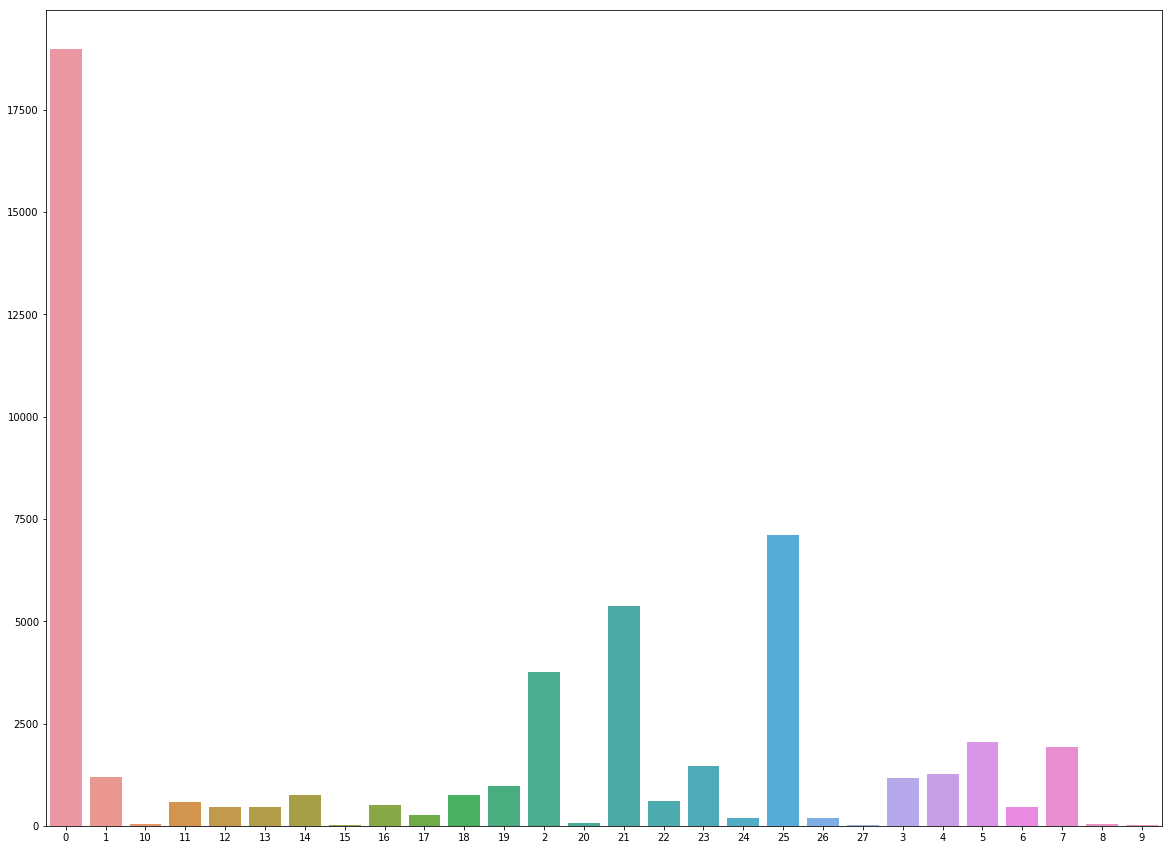

In [7]:
# Split the labels
labels = train_df["16 0"].apply(lambda x: x.split(" "))

# Create a counter. This initializes the count for each class with a value of zero
labels_count = {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0,
                "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0,
                "12": 0, "13": 0, "14": 0, "15": 0, "16": 0, "17": 0,
                "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0,
                "24": 0, "25": 0, "26": 0, "27": 0
                }

# Update the counter 
for label in labels:
    if len(label) > 1:
        for l in label:
            labels_count[str(l)]+=1
    else:
        labels_count[str(l)]+=1

# Plot         
plt.figure(figsize=(20,15))
sns.barplot(x=list(labels_count.keys()), y=list(labels_count.values()))
plt.show()

The imbalance is very very high.  
It might be hard to classify later but we will see that in the second part.

Data preparation

This function runs through the csv document, indexing the classes of each images.  
If the image contains more than one type of protein we will skip it for the moment, we will already try to solve a simple classification problem.

Even though the yellow layer was provided in the dataset. I chose not to use it because it is just a linear combination of the green and blue one if the images have been capture with a suitable filter.  

At the end we have two loaded lists, one of images and the other of labels.

In [6]:
def load_data(startIndex, stopIndex):
    images, labels = [], []
    path = "train/"
    with open("train.csv") as labels_file:
        csv_reader = csv.reader(labels_file)
        index = 0
        for line in csv_reader:
            if index >= startIndex and index < stopIndex:
                name = line[0]
                #we take a look at the proteins present in the image
                present_proteins = line[1].split()
                #if there are many we don't deal with it (for now)
                if len(present_proteins) == 1:
                    #reading and resizing
                    colored_image = np.zeros((128,128,3))
                    blue = cv2.resize(cv2.imread(path+name+"_blue.png", cv2.IMREAD_GRAYSCALE), (128, 128))
                    green = cv2.resize(cv2.imread(path+name+"_green.png", cv2.IMREAD_GRAYSCALE), (128, 128))
                    red = cv2.resize(cv2.imread(path+name+"_red.png", cv2.IMREAD_GRAYSCALE), (128, 128))

                    #putting all the filtered images into one
                    colored_image[:,:,0] = red
                    colored_image[:,:,1] = green
                    colored_image[:,:,2] = blue

                    images.append(colored_image)
                    labels.append(present_proteins[0])
                           
            if index >= stopIndex:
                break
            index += 1    
            
    return images, labels

In [8]:
def normalize(images):
    mean = np.mean(images)
    std = np.std(images)
    return np.array([(images[i] - mean) / std for i in range(len(images))])

def dummify(labels):
    dummies = np.zeros((len(labels),28))
    dummies[np.arange(len(labels)), np.array(labels, dtype='int')] = 1
    return dummies

In [15]:
def displaySample(images):
    fig = plt.figure(1, figsize=(17, 17))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)

    grid[0].imshow(images[0]/255, interpolation="bilinear")
    grid[0].tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)

    grid[1].imshow(images[1]/255, interpolation="bilinear")
    grid[1].tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)

    grid[2].imshow(images[2]/255, interpolation="bilinear")
    grid[2].tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)

    grid[3].imshow(images[3]/255, interpolation="bilinear")
    grid[3].tick_params(axis='both', which='both', bottom=False, top=False, 
                    labelbottom=False, right=False, left=False, labelleft=False)

As the neural network work better with normalized input, we replace it by its z-score normalization.

We also transform our classes "1,2,3,4,..,27" to its dummy (vectorized) version.  

And pickle our result to exploit it later.

In [10]:
for i in range(7):
    
    images, labels = load_data(i*4000,(i+1)*4000)
    images, labels = shuffle(images, labels)
    
    #we preserve souvenirs before the normalization
    souvenirs = images[0:4]
    
    images = normalize(images)
    dummified_labels = dummify(labels)
    
    with open("pickles/images"+str(i)+".pickle", "wb") as file:
        pickle.dump(images, file)
    with open("pickles/labels"+str(i)+".pickle", "wb") as file:
        pickle.dump(dummified_labels, file)
        
    print("Batch {} created successfully" .format(i))

Batch 0 created successfully
Batch 1 created successfully
Batch 2 created successfully
Batch 3 created successfully
Batch 4 created successfully
Batch 5 created successfully
Batch 6 created successfully


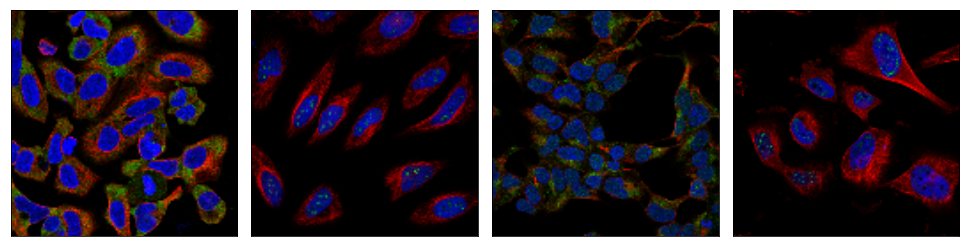

In [16]:
displaySample(souvenirs)